## The genomic regions in question

In `05_rec_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb

The following parameter was only changed for 100kb resolution:

* Smoothing: No smoothing, 5 bins (500kb) 

Resulting in **45** .csv files. They are saved to `../results/rec_compartments/`.


### Load the data

In [4]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/rec_compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)
        dataframes[key]['length'] = dataframes[key]['end'] - dataframes[key]['start']

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')
ech90['length'] = ech90['end'] - ech90['start']

# Load the chromosome sizes
chromsizes = (pd.read_csv(
    '../data/rheMac10.filtered.chrom.sizes', 
    sep='\t', 
    index_col='chrom', 
    header=None, 
    names=['chrom','size'])
.to_dict()['size']
)


## Time to unleash `genominterv` on the .csv files


### Define a plotting function

In [2]:
# Kaspers plotting function
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(10, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

In [3]:
# My plotting function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect

%config InlineBackend.figure_format = 'svg'



def plot_regions(query=None, annot=None, intersect=None):
    chrom = annot['chrom'].unique()[0]
    chromsize = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])
    chromsize = chromsize[chromsize['chrom'] == chrom]['size'].values[0]
    
    # Define the plot
    height = 1 + (1 if query is not None else 0) + (1 if intersect is not None else 0)
    height = height * 0.75

    f, ax = plt.subplots(figsize=(10, height), sharex=True)
    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=0, alpha=0.6)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        lbl = annot['label'].unique()[0] if 'label' in annot.columns else 'A-Comp'
        ax.set_ylabel(lbl, rotation=0, fontsize=10, labelpad=30)

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.2, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=0, alpha=0.6)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(chrom, loc='left', fontsize=10)
            qax.set_ylabel('ECH90', rotation=0, fontsize=10, labelpad=30)
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.2, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel('Intersect', rotation=0, fontsize=10, labelpad=30)



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    plt.tight_layout()
    return f, ax



### Test with a subsample of the data

(<Figure size 1000x225 with 3 Axes>, <Axes: ylabel='annot'>)

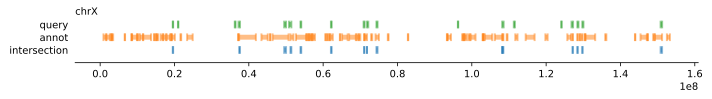

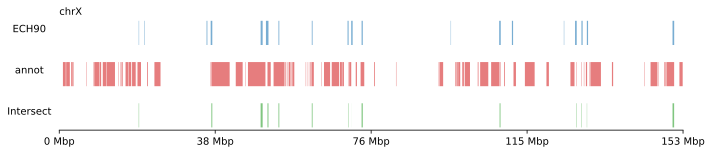

In [4]:

annot = dataframes['round_spermatid_100kb_arms']
query = ech90
intersect = interval_intersect(annot, query)

plot_intervals(query, annot, intersection=intersect)
plot_regions(query, annot, intersect)

Tests for round_spermatid_100kb_arms_smoothed
Proximity: TestResult(statistic=0.3711999999999999, pvalue=0.0174)
Jaccard: 0.03771152626674943

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.51525, pvalue=0.0001)
Jaccard: 0.046023479610810235

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.46520000000000006, pvalue=0.0052)
Jaccard: 0.042623832902054265

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.37199999999999966, pvalue=0.0117)
Jaccard: 0.046543092859550536



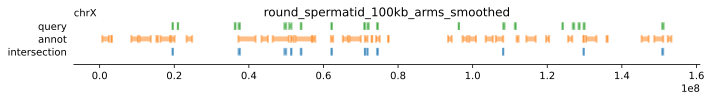

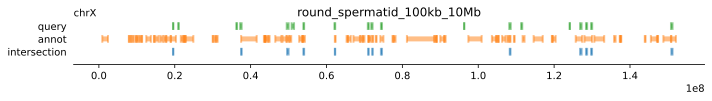

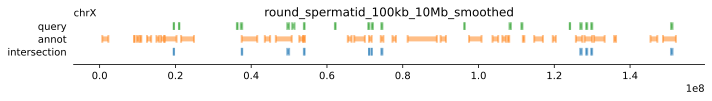

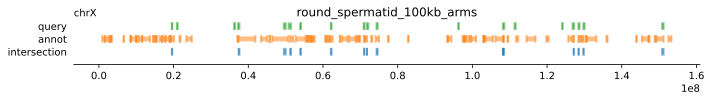

In [5]:
from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect, jaccard_stat

annot = dataframes['round_spermatid_100kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        intersection = interval_intersect(query, annot)
        plot_intervals(query=query, annot=annot, intersection=intersection)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard_stat(query, annot))
        print()



### Bootstrap to get a p-value

In [6]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard_stat(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

In [7]:
jacccard_stat, p_value

(0.046543092859550536, 0.112)

### Partition the A-compartments into regions *around* the edges 

In [8]:
from genominterv import interval_collapse, interval_union

df = dataframes['round_spermatid_100kb_arms']

start_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df.apply(lambda x: max(x['start'] - x['resolution'], 0), axis=1),
    'end': df['start']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'start_edge'
})
end_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['end']-1*df['resolution'],
    'end': df.apply(lambda x: min(x['end'] + x['resolution'], chromsizes['chrX']), axis=1),
    'resolution': df['resolution'],
    'label': 'end_edge'
})

# The end cannot exceed the chromosome size
test_df = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
interval_collapse(test_df)

,start,end,chrom
0,800000,1000000,chrX
1,1500000,1800000,chrX
2,2500000,2700000,chrX
3,2800000,3300000,chrX
4,3400000,3600000,chrX
...,...,...,...
91,148700000,148900000,chrX
92,149000000,149400000,chrX
93,151100000,151300000,chrX
94,152400000,152600000,chrX


In [9]:
import os
from genominterv import interval_collapse

for key, df in dataframes.items():
    outdir = '../results/rec_edges'
    edge_csv_name = os.path.join(outdir,f'{key+'_edges.csv'}')
    if not os.path.exists(edge_csv_name):
        res = df['resolution'].unique()[0]

        start_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df.apply(lambda x: max(x['start'] - x['resolution'], 0), axis=1),
            'end': df['start']+1*df['resolution'],
            'resolution': df['resolution'],
            'label': 'start_edge'
        })
        end_edge = pd.DataFrame({
            'chrom': df['chrom'],
            'start': df['end']-1*df['resolution'],
            'end': df.apply(lambda x: min(x['end'] + x['resolution'], chromsizes['chrX']), axis=1),
            'resolution': df['resolution'],
            'label': 'end_edge'
        })

        if not os.path.exists(outdir):
            os.makedirs(outdir)

        tmp = pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])
        interval_collapse(tmp).assign(resolution=res).to_csv(edge_csv_name, index=False)


## Import edges

In [5]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/rec_edges/'

# Create a dictionary to store the DataFrames
edge_df = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_edges_', '')
        key = os.path.splitext(key)[0]
        edge_df[key] = pd.read_csv(filepath)
        edge_df[key]['length'] = edge_df[key]['end'] - edge_df[key]['start']

# The `edges` dictionary now contains the DataFrames
print(edge_df.keys())
print(edge_df['fibroblast_100kb_10Mb_edges'].columns)

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['pachytene_spermatocyte_100kb_arms_edges', 'pachytene_spermatocyte_100kb_full_smoothed_edges', 'pachytene_spermatocyte_500kb_full_edges', 'fibroblast_100kb_full_smoothed_edges', 'pachytene_spermatocyte_100kb_10Mb_edges', 'sperm_100kb_10Mb_smoothed_edges', 'round_spermatid_100kb_10Mb_smoothed_edges', 'sperm_100kb_full_edges', 'round_spermatid_100kb_full_edges', 'round_spermatid_500kb_arms_edges', 'sperm_500kb_arms_edges', 'spermatogonia_100kb_arms_edges', 'fibroblast_100kb_10Mb_smoothed_edges', 'pachytene_spermatocyte_100kb_10Mb_smoothed_edges', 'spermatogonia_500kb_full_edges', 'fibroblast_100kb_10Mb_edges', 'round_spermatid_100kb_full_smoothed_edges', 'fibroblast_100kb_arms_edges', 'fibroblast_500kb_full_edges', 'spermatogonia_100kb_arms_smoothed_edges', 'spermatogonia_100kb_10Mb_edges', 'round_spermatid_500kb_10Mb_edges', 'sperm_100kb_full_smoothed_edges', 'sperm_500kb_10Mb_edges', 'fibroblast_100kb_arms_smoothed_edges', 'pachytene_spermatocyte_100kb_arms_smoothed_edges', 

In [6]:
from genominterv import interval_intersect

samples = dataframes.keys()
#samples = ['round_spermatid_100kb_arms', 'round_spermatid_100kb_10Mb', 'sperm_100kb_arms', 'sperm_100kb_10Mb']

comps = {key:dataframes[key] for key in samples}
edges = {key:edge_df[f'{key}_edges'] for key in samples}

comp_intersects = {key:interval_intersect(comp, ech90).assign(length = lambda x: x['end'] - x['start']) for key, comp in comps.items()}
edge_intersects = {key:interval_intersect(edge, ech90).assign(length = lambda x: x['end'] - x['start']) for key, edge in edges.items()}




## For a single sample only ##
# sample = 'round_spermatid_100kb_arms'

# full_df = dataframes[sample]
# full_intersect = interval_intersect(full_df, ech90).assign(length=lambda x: x['end'] - x['start'])
# edge_intersect = interval_intersect(edge_df[f'{sample}_edges'], ech90).assign(length=lambda x: x['end'] - x['start'])

# edge_df = edge_df[f'{sample}_edges']

# # Plot full
# plot_regions(ech90, full_df, full_intersect)
# plt.suptitle('All edges')

# # Plot edge
# plot_regions(ech90, edge_df, edge_intersect)
# plt.suptitle('Edges only')


In [9]:
### Some stats about the data and intersections ###

stats = pd.DataFrame({
    'Sample': samples,
    'Total regions': [comp.shape[0] for comp in comps.values()],
    'Total regions on ECH90': [comp_intersect.shape[0] for comp_intersect in comp_intersects.values()],
    'Total regions on edges': [edge_intersect.shape[0] for edge_intersect in edge_intersects.values()],
    'Prop regions on ECH90': [comp_intersect.shape[0] / ech90.shape[0] for comp, comp_intersect in zip(comps.values(), comp_intersects.values())],
    'Total bp': [comp['length'].sum() for comp in comps.values()],
    'Total bp on ECH90': [comp_intersect['length'].sum() for comp_intersect in comp_intersects.values()],
    'Total bp on edges': [edge_intersect['length'].sum() for edge_intersect in edge_intersects.values()],
    'Prop bp on ECH90': [comp_intersect['length'].sum() / ech90['length'].sum() for comp, comp_intersect in zip(comps.values(), comp_intersects.values())],
})


#df[['Source', 'Rest']] = df['Sample'].str.extract(r'^(.*?)(_\d+\w+.*)')
stats[['source', 'res', 'view', 'smoothed']] = stats['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
stats['smoothed'] = stats['smoothed'].notna() # Convert to boolean
stats[['Sample','source', 'res', 'view', 'smoothed','Prop regions on ECH90', 'Prop bp on ECH90']]


# # Determine the proportion of total regions in ECH90 that lies on compartments

# print("Proportion of ECH90 on: (#count)")

# # Proportion of ECH90 on full regions
# print(f'\tFull: {full_intersect.shape[0] / ech90.shape[0]}')
# print(f'\tEdge: {edge_intersect.shape[0] / ech90.shape[0]}')


# print("\nProportion of ECH90: (#bpairs)")

# # Proportion of ECH90 on full regions
# print(f'\tFull: {full_intersect['length'].sum() / ech90['length'].sum()}')
# print(f'\tEdge: {edge_intersect['length'].sum() / ech90['length'].sum()}')

# # Determine the proportion of total regions in ECH90 that lies on compartment edges


# # What is the total length of ech90 regions and edges
# print("\nTotal length of:")
# print(f'\tECH90:   {(ech90['end'] - ech90['start']).sum()} bp')
# print(f'\tEdge:   {(edge_df["end"] - edge_df["start"]).sum()} bp')
# print(f'\tFull:   {(full_df["end"] - full_df["start"]).sum()} bp')

## Plot
# f, ax = plot_regions(ech90, edge_df, full_intersect)

# for ax in list(f.axes):
#     if ax.get_ylabel() == 'ECH90':
#         #ax.set_ylabel('Edges', rotation=0, fontsize=10, labelpad=30)
#         pass
#     if ax.get_ylabel() in ("query", "A-Comp"):
#         ax.set_ylabel('Edges', rotation=0, fontsize=10, labelpad=30)
#     if ax.get_ylabel() == 'Intersect':
#         #ax.set_ylabel('end_edge \nintersect', rotation=0, fontsize=10, labelpad=30)
#         pass


,Sample,source,res,view,smoothed,Prop regions on ECH90,Prop bp on ECH90
0,spermatogonia_500kb_arms,spermatogonia,500kb,arms,False,0.421053,0.489351
1,round_spermatid_500kb_full,round_spermatid,500kb,full,False,0.368421,0.418981
2,fibroblast_500kb_full,fibroblast,500kb,full,False,0.684211,0.529916
3,pachytene_spermatocyte_100kb_arms_smoothed,pachytene_spermatocyte,100kb,arms,True,0.684211,0.632145
4,pachytene_spermatocyte_500kb_full,pachytene_spermatocyte,500kb,full,False,0.368421,0.362651
5,pachytene_spermatocyte_100kb_full,pachytene_spermatocyte,100kb,full,False,0.473684,0.365265
6,round_spermatid_100kb_arms_smoothed,round_spermatid,100kb,arms,True,0.631579,0.412828
7,fibroblast_100kb_arms_smoothed,fibroblast,100kb,arms,True,0.684211,0.499297
8,fibroblast_100kb_full,fibroblast,100kb,full,False,0.842105,0.550167
9,round_spermatid_100kb_full,round_spermatid,100kb,full,False,0.421053,0.472204


### Do testing of the edges

In [10]:
%%capture
# Define what we are testing

print("""
Goal: To test whether ECH90 regions are enriched in compartment edges
Query: ECH90
Annotation: Start and end edges of compartments

Hypothesis: 
      ECH90 regions are enriched in compartment edges
Null hypothesis: 
      ECH90 regions are not enriched in compartment edges

Tests: 
* Proximity test: 
      tests whether the query regions are closer to 
      the annotation regions than expected by chance. 
      NB regions can not overlap, so we need to collapse the annotation regions

* Jaccard index: 
      tests the similarity between the query and annotation regions, 
      where a value of 1 indicates perfect overlap
""")

In [70]:
### Proximity test ###
import os.path as op
from genominterv import proximity_test, interval_diff

proximity_file = '../results/proximity_test_results.csv'
if not op.exists(proximity_file):
    proximity_res = pd.DataFrame({})

    for sample in samples:
        query_comp = ech90
        query_edge = ech90
        annot_comp = comps[sample]
        annot_edge = edges[sample]

        # Get non-overlapping query regions
        non_ovl_query_comp = interval_diff(query_comp, annot_comp)
        non_ovl_query_edge = interval_diff(query_edge, annot_edge)

        proximity_comp = proximity_test(non_ovl_query_comp, annot_comp, two_sided=True)
        proximity_edge = proximity_test(non_ovl_query_edge, annot_edge, two_sided=True)

        proximity_res = pd.concat([proximity_res, pd.DataFrame({
            'Sample': sample,
            'Query': 'ECH90',
            'Comp Statistic': proximity_comp.statistic,
            'Edge Statistic': proximity_edge.statistic,
            'Comp P-value': proximity_comp.pvalue,
            'Edge P-value': proximity_edge.pvalue
        }, index=[0])
        ])

        # Swap query and annotation
        query_comp, annot_comp = annot_comp, query_comp
        query_edge, annot_edge = annot_edge, query_edge

        non_ovl_query_comp = interval_diff(query_comp, annot_comp)
        non_ovl_query_edge = interval_diff(query_edge, annot_edge)

        proximity_comp = proximity_test(non_ovl_query_comp, annot_comp, two_sided=True)
        proximity_edge = proximity_test(non_ovl_query_edge, annot_edge, two_sided=True)

        proximity_res = pd.concat([proximity_res, pd.DataFrame({
            'Sample': sample,
            'Query': 'Edge',
            'Comp Statistic': proximity_comp.statistic,
            'Edge Statistic': proximity_edge.statistic,
            'Comp P-value': proximity_comp.pvalue,
            'Edge P-value': proximity_edge.pvalue
        }, index=[0])
        ])
    proximity_res.to_csv(proximity_file, index=False)
else: 
    proximity_res = pd.read_csv(proximity_file)

## For a single sample only ##
# # Define the query and annotation
# query = ech90
# annot = edge_df

# # display(interval_diff(query, annot), interval_diff(annot, query))

# # Calculate the non-overlapping query regions
# non_ovl_query_full = interval_diff(query, annot)


# # Perform the proximity test
# proximity_full = proximity_test(non_ovl_query_full, annot, two_sided=True)


# print("Proximity test results: query=ECH90, annotation=edge_df")
# print("non_ovl_query: the parts of ECH90 that do not overlap with edge_df")
# print(f"\tstatistic: {proximity_full.statistic}, \n\tp-value: {proximity_full.pvalue}")

# query, annot = annot, query

# # Calculate the non-overlapping query regions
# non_ovl_query_full = interval_diff(query, annot)


# print("\nProximity test results: query=edge_df, annotation=ECH90")
# print("non_ovl_query: the parts of edge_df that do not overlap with ECH90")
# proximity_full = proximity_test(non_ovl_query_full, annot, two_sided=True)
# print(f"\tstatistic: {proximity_full.statistic}, \n\tp-value: {proximity_full.pvalue}")


In [12]:
### Jaccard index ###
import os.path as op
from genominterv import jaccard_stat, bootstrap

jaccard_file = '../results/jaccard_test_results.csv'
if not op.exists(jaccard_file):
    b = 1000
    @bootstrap(chromsizes, samples=b)
    def jaccard_bootstrap(query, annot):
        return jaccard_stat(query, annot)


    jaccard_res = pd.DataFrame({})

    for sample in samples:
        query_comp = ech90
        query_edge = ech90
        annot_comp = comps[sample]
        annot_edge = edges[sample]

        jaccard_comp = jaccard_bootstrap(query_comp, annot_comp)
        jaccard_edge = jaccard_bootstrap(query_edge, annot_edge)

        jaccard_res = pd.concat([jaccard_res, pd.DataFrame({
            'Sample': sample,
            'Query': 'ECH90',
            'Comp Index': jaccard_comp[0],
            'Edge Index': jaccard_edge[0],
            'Comp P-value': jaccard_comp[1],
            'Edge P-value': jaccard_edge[1]
        }, index=[0])
        ])

        query_comp, annot_comp = annot_comp, query_comp
        query_edge, annot_edge = annot_edge, query_edge

        jaccard_comp = jaccard_bootstrap(query_comp, annot_comp)
        jaccard_edge = jaccard_bootstrap(query_edge, annot_edge)

        jaccard_res = pd.concat([jaccard_res, pd.DataFrame({
            'Sample': sample,
            'Query': 'Edge',
            'Comp Index': jaccard_comp[0],
            'Edge Index': jaccard_edge[0],
            'Comp P-value': jaccard_comp[1],
            'Edge P-value': jaccard_edge[1]
        }, index=[0])
        ])

    # Write
    jaccard_res.to_csv(jaccard_file, index=False)
else:
    # Read
    jaccard_res = pd.read_csv(jaccard_file)

## For a single sample only ##
# # Calculate the Jaccard index
# query = ech90
# annot = edge_df
# jaccard_stat_full, p_value_full = jaccard_bootstrap(query,annot)

# print("\nJaccard results: query=ECH90, annotation=edge_df")
# print(f"ECH90 is bootstrapped n={b}")
# print(f"\tIndex: {jaccard_stat_full}, \n\tp-value: {p_value_full}")

# query, annot = annot, query

# jaccard_stat_full, p_value_full = jaccard_bootstrap(query,annot)

# print("\nJaccard results: query=edge_df, annotation=ECH90")
# print(f"Edge_df is bootstrapped n={b}")
# print(f"\tIndex: {jaccard_stat_full}, \n\tp-value: {p_value_full}")

## Plot some summary statistics

In [71]:
# Split sample column:
proximity_res = pd.read_csv(proximity_file)

proximity_res[['source', 'resolution', 'view', 'smoothed']] = proximity_res['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
proximity_res['smoothed'] = proximity_res['smoothed'].notna()
proximity_res = proximity_res.melt(
    id_vars=['Sample', 'source', 'resolution', 'view', 'smoothed', 'Query'],
    value_vars=['Comp P-value', 'Edge P-value'], 
     var_name='type', value_name='p-value',)

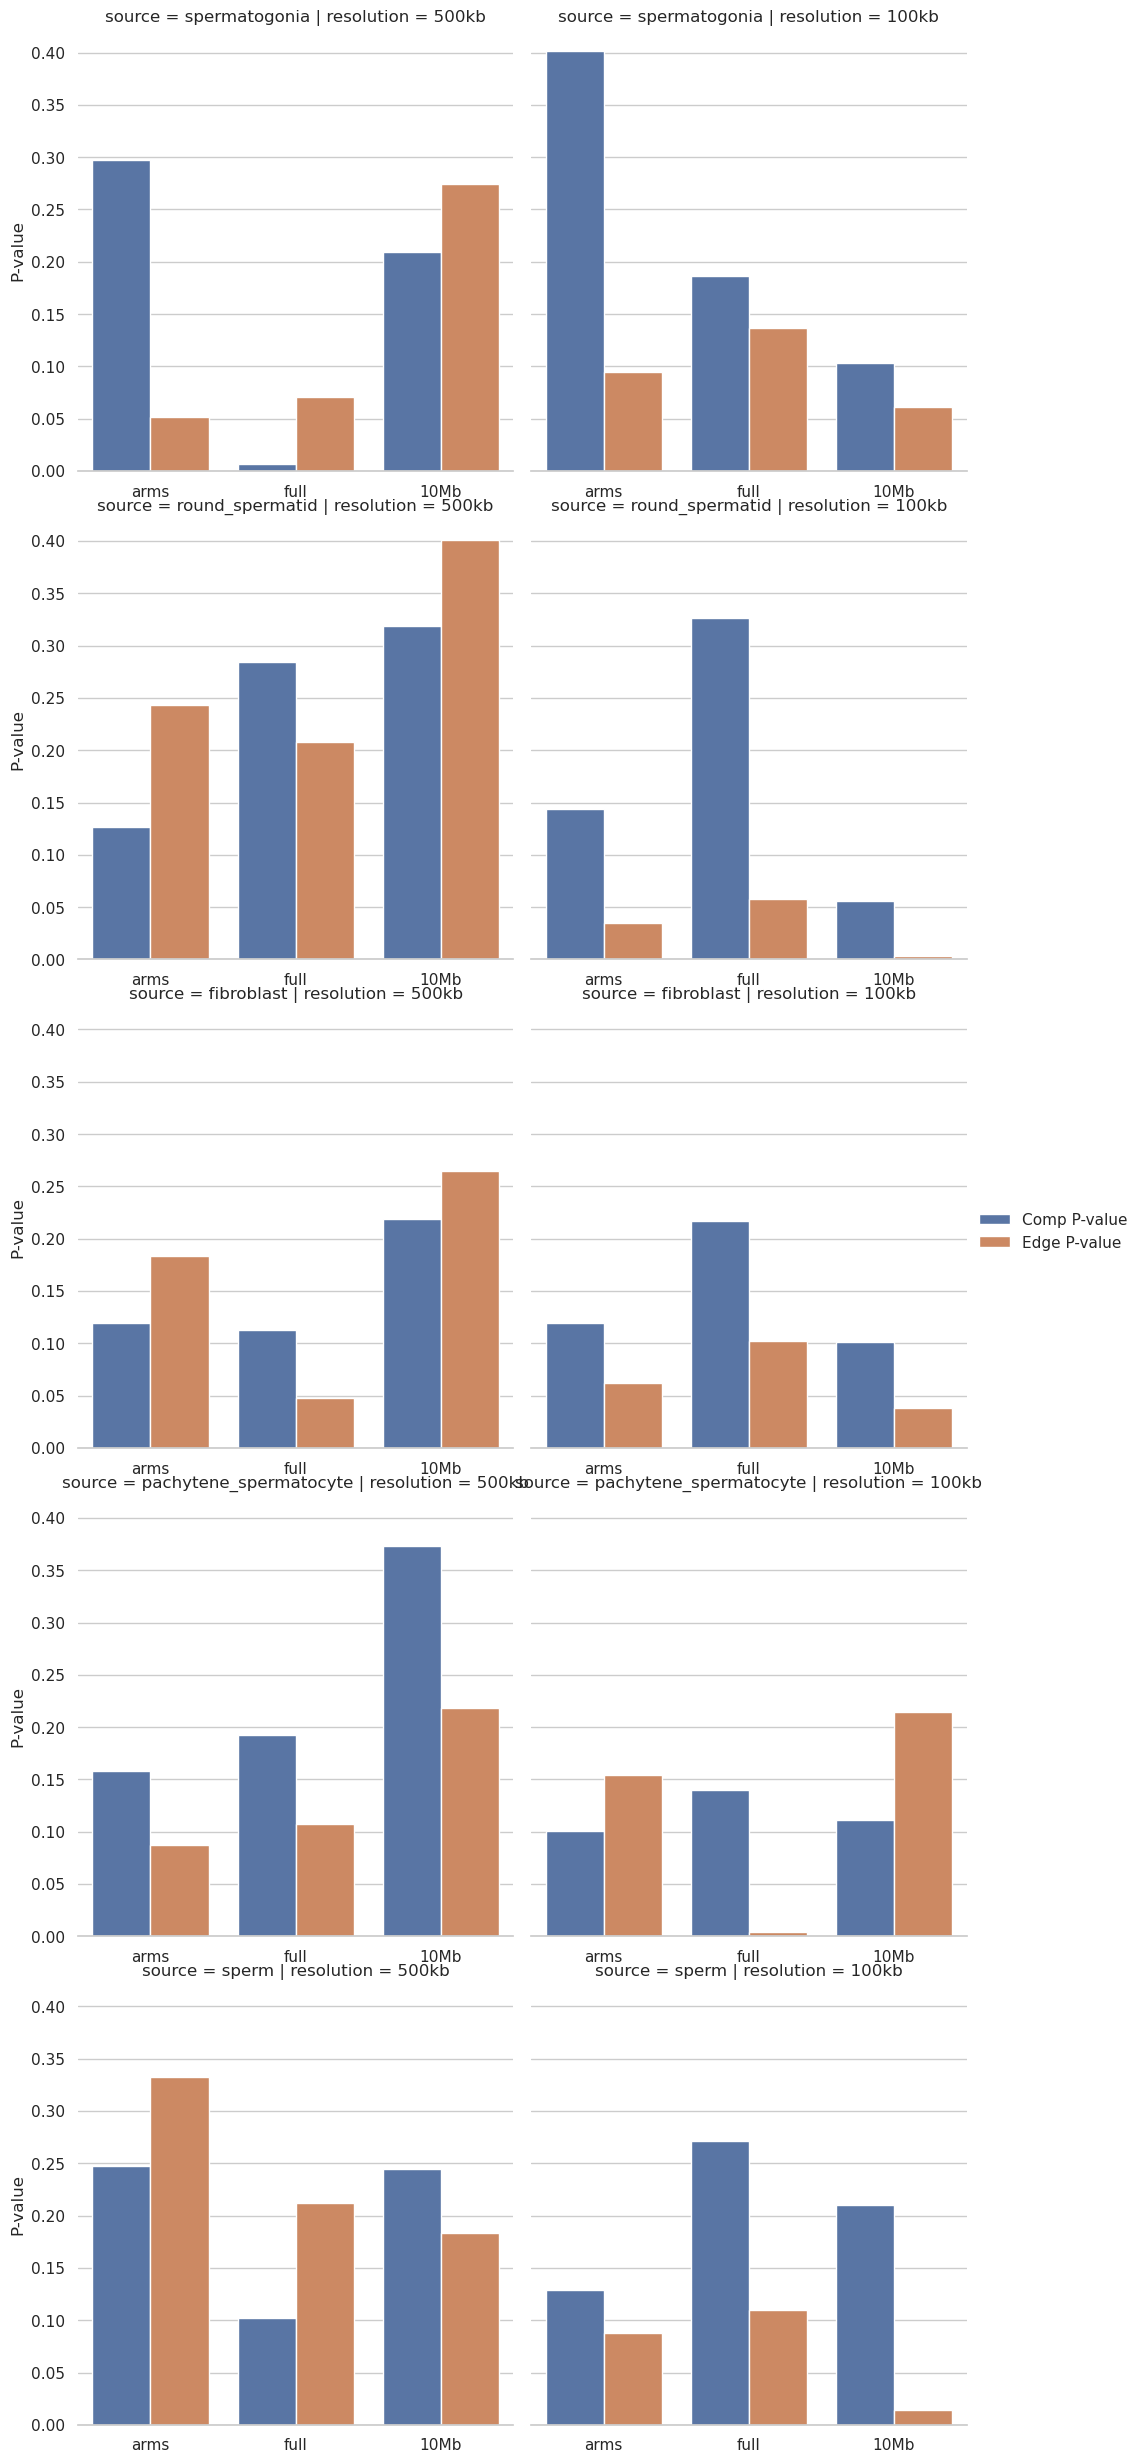

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Group the results by source and resolution
# group = ["fibroblast", 'round_spermatid']
# # Plot the results from @group
# plot_group = proximity_res.query(f'source in @group')

sns.set_theme(style="whitegrid")

g = sns.catplot(
    proximity_res, kind='bar', row='source',
    x='view', y='p-value', hue='type', col='resolution', 
    errorbar=None)

g.despine(left=True)
g.set_axis_labels("", "P-value")
g.legend.set_title('')

for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)


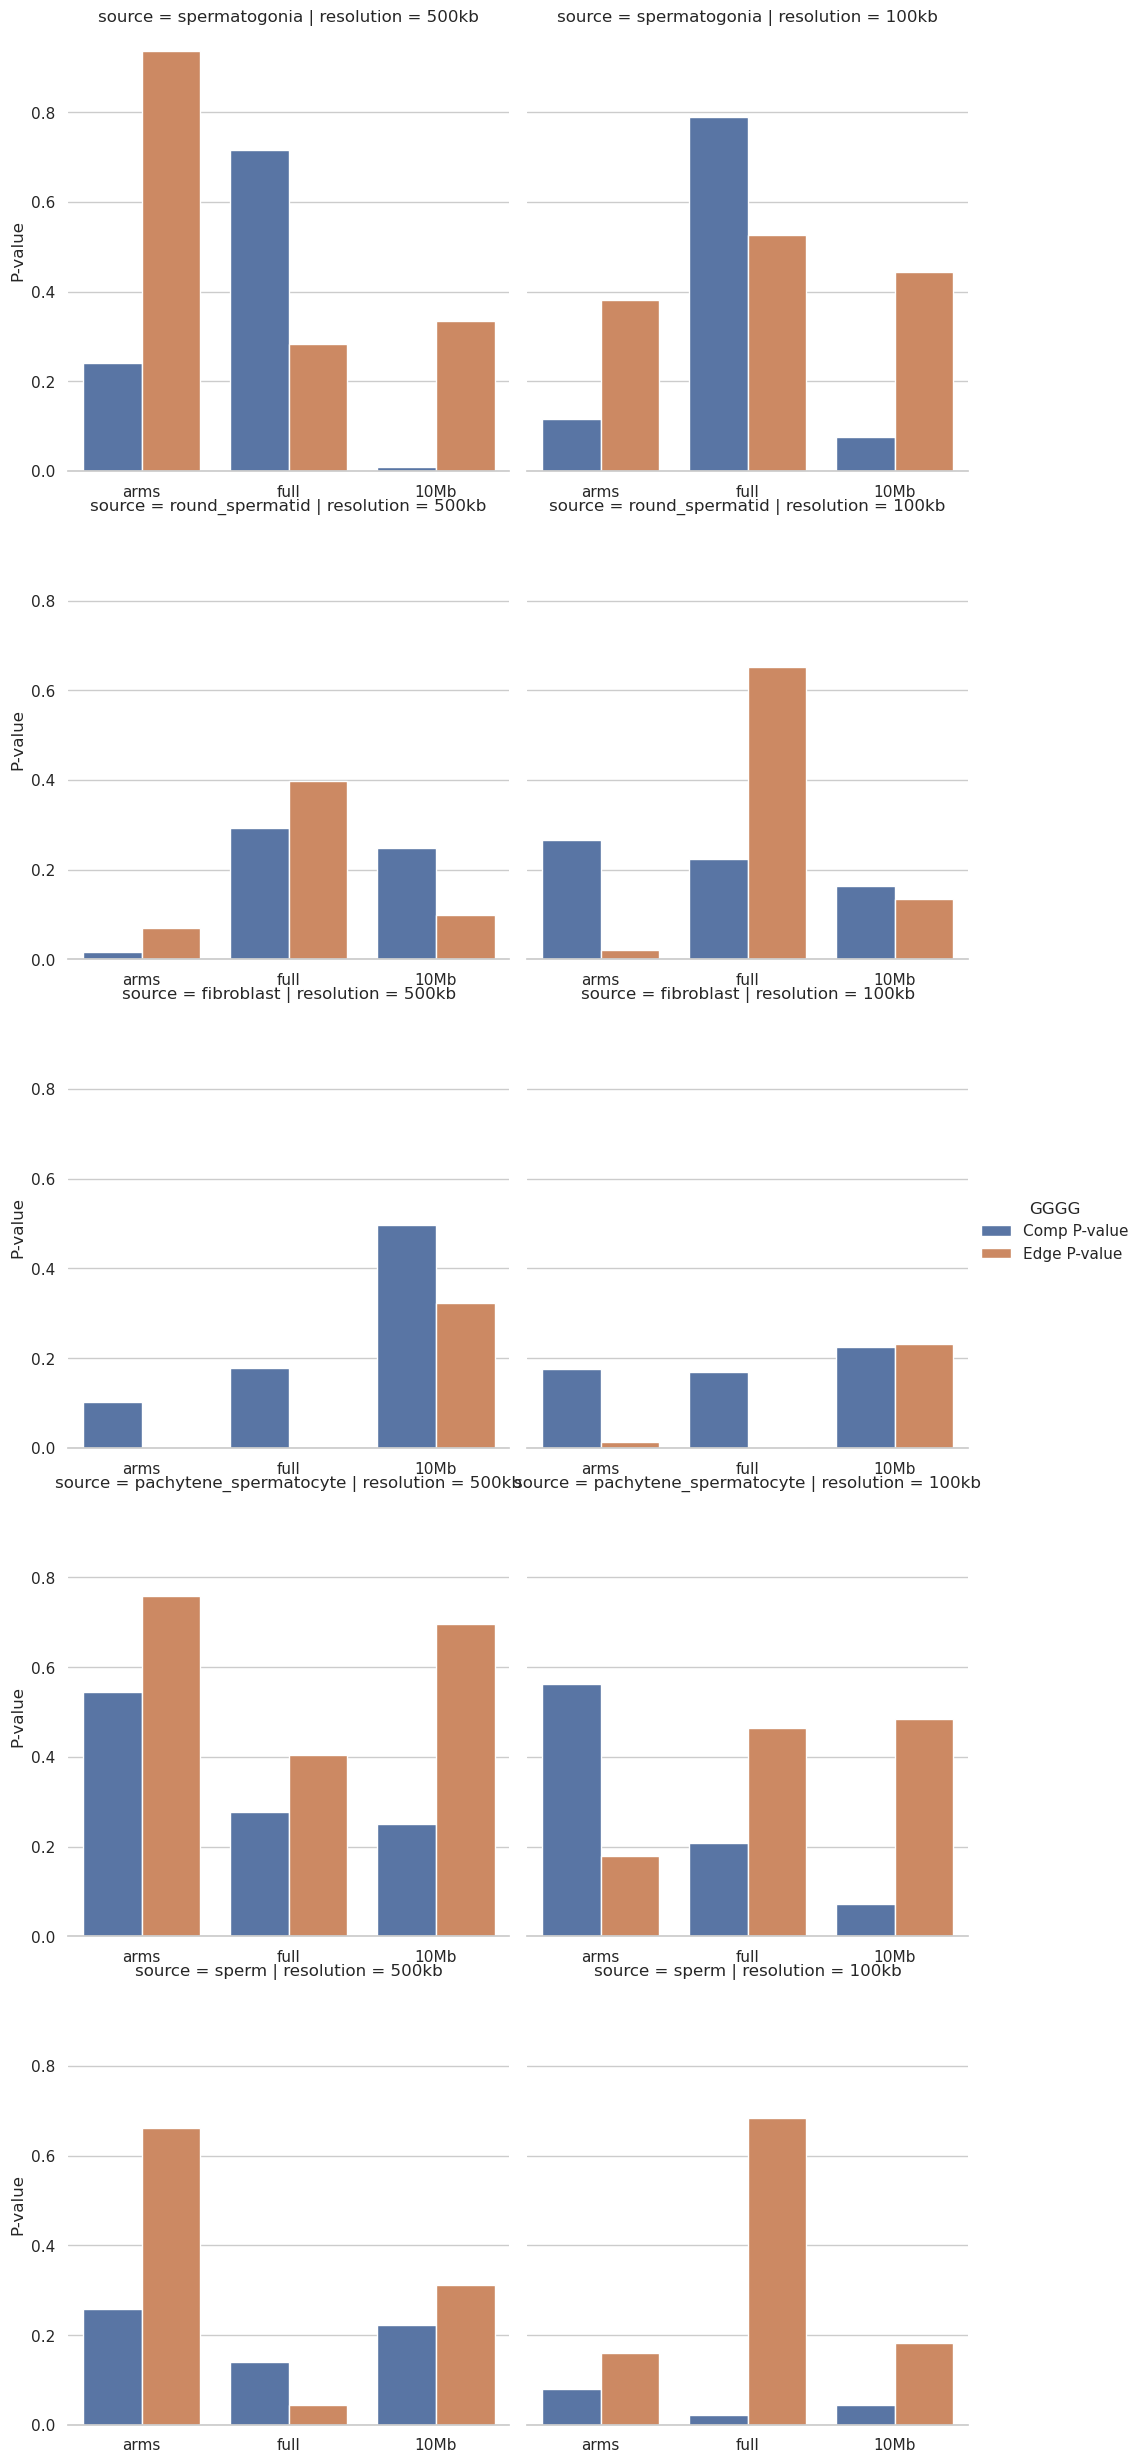

In [ ]:
# Now do the same for the Jaccard index

jaccard_res = pd.read_csv(jaccard_file)

jaccard_res[['source', 'resolution', 'view', 'smoothed']] = jaccard_res['Sample'].str.extract(r'^(.*?)_(100kb|500kb)_(full|arms|10Mb)(?:_(smoothed))?$')
jaccard_res['smoothed'] = jaccard_res['smoothed'].notna()
jaccard_res = jaccard_res.melt(
    id_vars=['Sample', 'source', 'resolution', 'view', 'smoothed', 'Query'],
    value_vars=['Comp P-value', 'Edge P-value'], 
     var_name='type', value_name='p-value',)

# # Group the results by source and resolution
# group = ["fibroblast", 'round_spermatid']
# # Plot the results from @group
# plot_group = jaccard_res.query(f'source in @group')
sns.set_theme(style="whitegrid")

g = sns.catplot(
    jaccard_res, kind='bar', row='source',
    x='view', y='p-value', hue='type', col='resolution', 
    errorbar=None)

g.despine(left=True)
g.set_axis_labels("", "P-value")
g.legend.set_title('')
for axis in g.axes.flat:
    axis.tick_params(labelbottom=True)


## Geneinfo 

How does the edges align with genes?

This first plot is just to figure out how to plot with `gene_plot`.

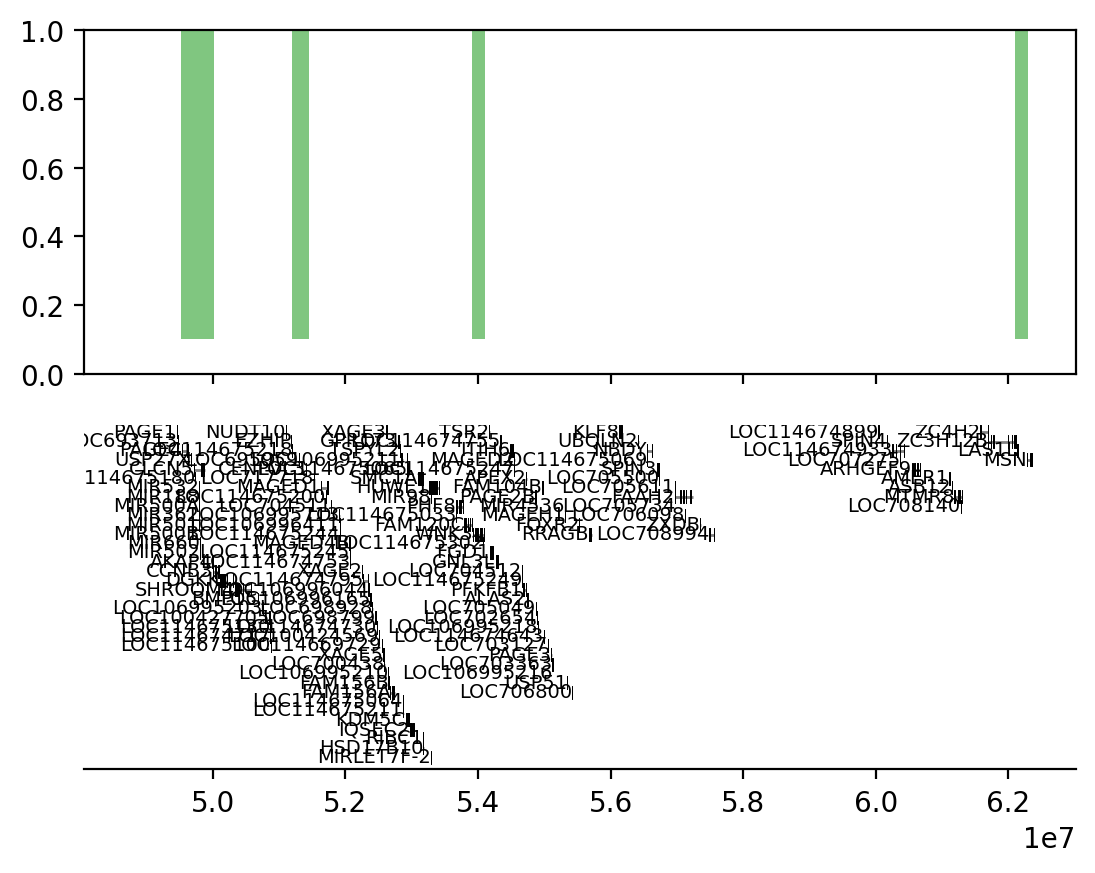

In [15]:
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

start = full_intersect['start'][2]
end = full_intersect['end'][5]

rectangles = [Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][2:6], full_intersect['end'][2:6])]

pc = PatchCollection(rectangles, match_original=True)

ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10')
ax.add_collection(pc)

#### Get the geneinfo for all intersections between edges and ECH90

And write to a csv file. If the file exists, read it with pandas.

In [ ]:
# Use get_genes_region
import os.path as op
import geneinfo as gi
import pandas as pd
from os import makedirs as mkdir

genes_dir = '../results/rec_edge_genes/'
if not op.exists(genes_dir):
    mkdir(genes_dir)
    
genes_file = op.join(genes_dir,'rs_edges_100kb_genes.csv')

if not op.exists(genes_file):
    genes = pd.concat(
        full_intersect.apply(
            lambda x: gi.get_genes_region_dataframe('chrX', x['start'], x['end'], assembly='rheMac10'), 
            axis =1
            ).to_list(),
        ignore_index=True
    )
    genes.to_csv(genes_file, index=False) 
else: 
    genes = pd.read_csv(genes_file)

In [18]:
genes_list = genes['name'].unique().tolist()
genes_list

['SH3KBP1',
 'MIR7206',
 'LANCL3',
 'XK',
 'CYBB',
 'LOC696657',
 'DYNLT3',
 'PAGE4',
 'USP27X',
 'CLCN5',
 'LOC114675180',
 'MIR532',
 'MIR188',
 'MIR500A',
 'MIR362',
 'MIR501',
 'MIR500B',
 'MIR660',
 'MIR502',
 'AKAP4',
 'CCNB3',
 'LOC114675218',
 'LOC695959',
 'CENPVL3',
 'FAM120C',
 'WNK3',
 'LOC114675302',
 'ZC3H12B',
 'LAS1L',
 'MSN',
 'ATRX',
 'MAGT1',
 'LOC114675151',
 'COX7B',
 'ATP7A',
 'ALG13',
 'LOC706958',
 'TRPC5',
 'ENOX2',
 'RAP2C',
 'LOC114675176',
 'DKC1',
 'LOC114675231',
 'MPP1',
 'SMIM9',
 'F8',
 'H2AFB3',
 'FUNDC2',
 'CMC4',
 'MTCP1',
 'BRCC3',
 'LOC703257']

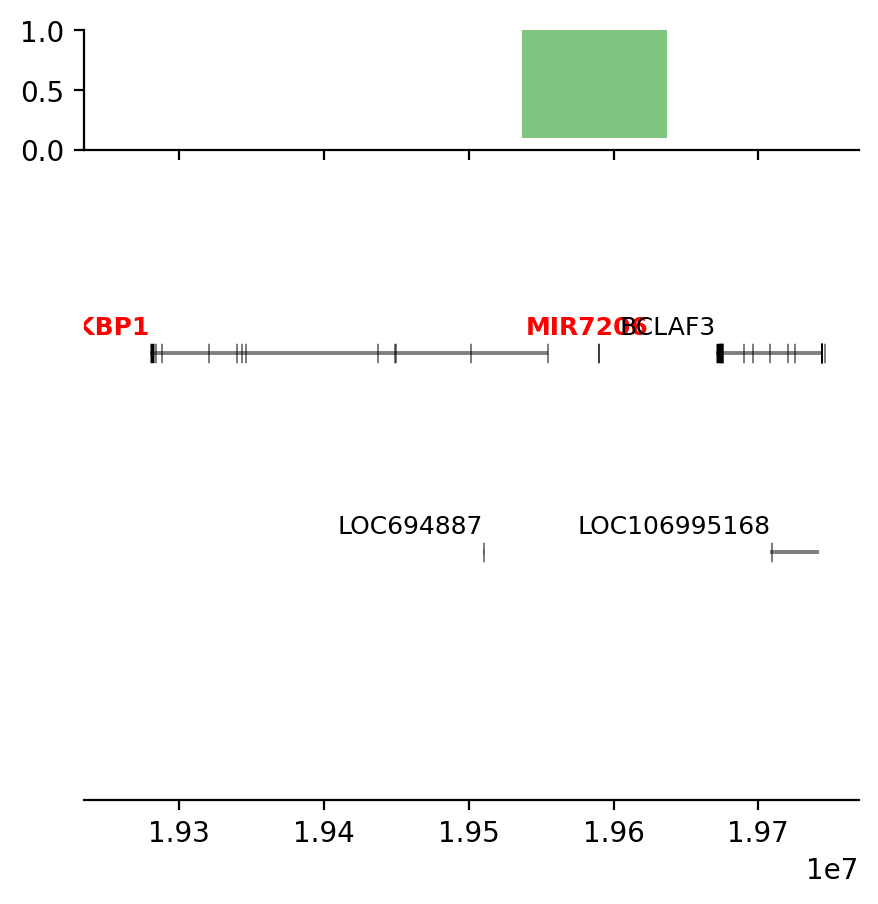

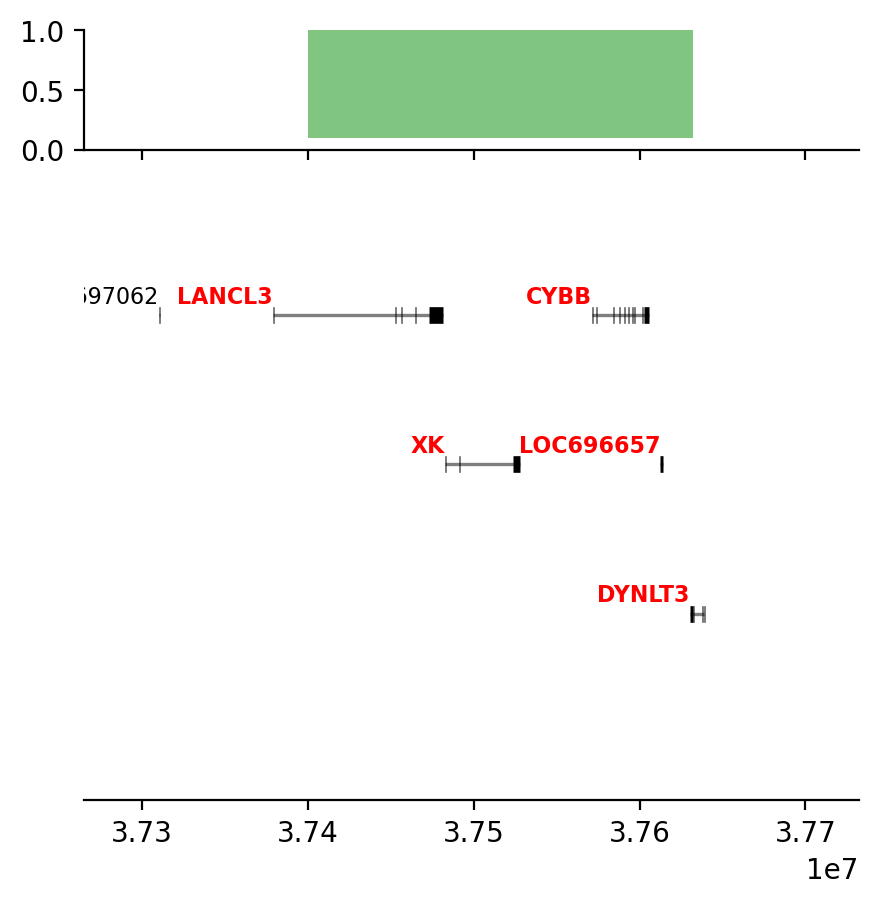

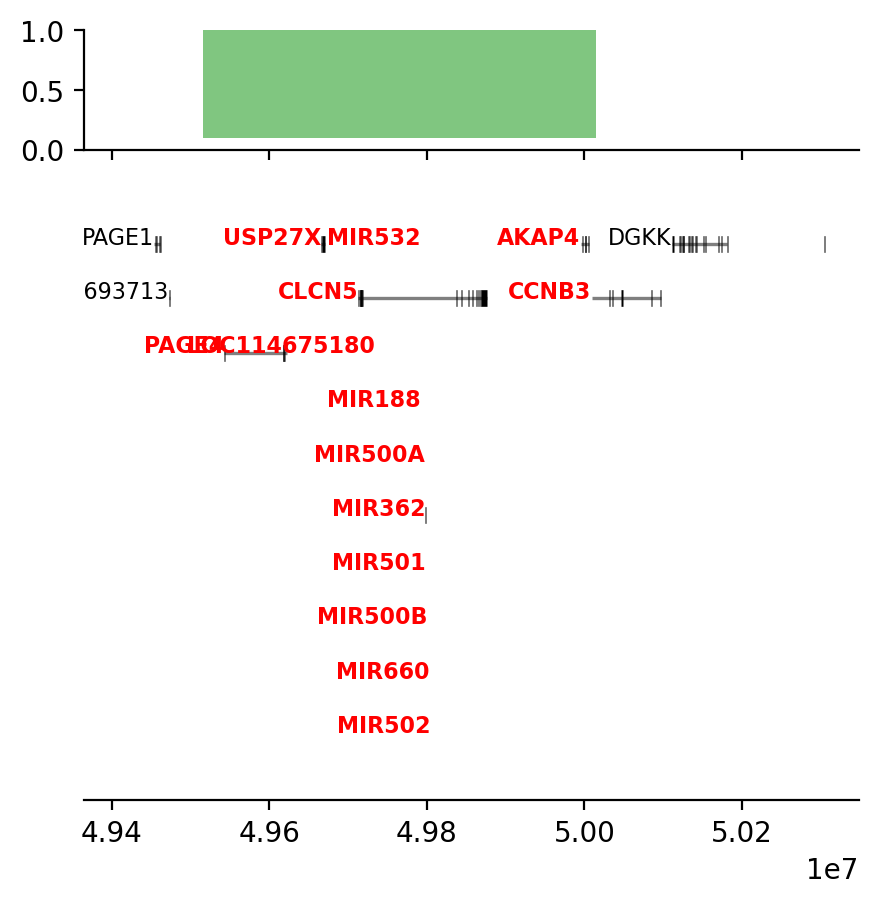

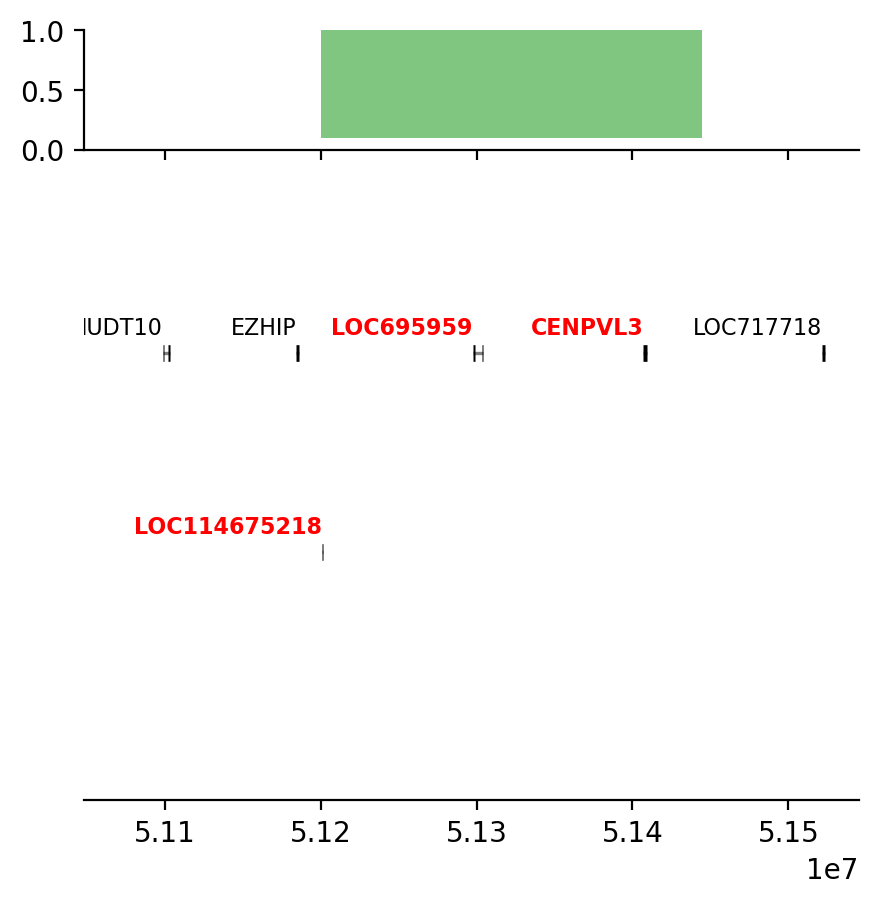

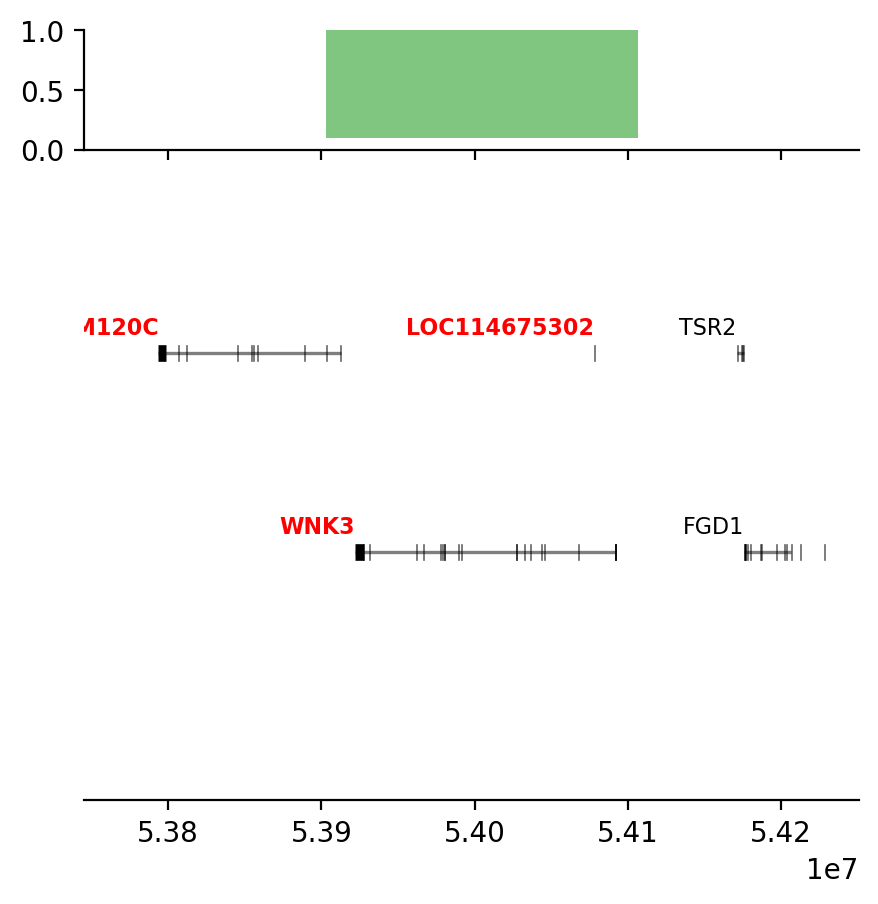

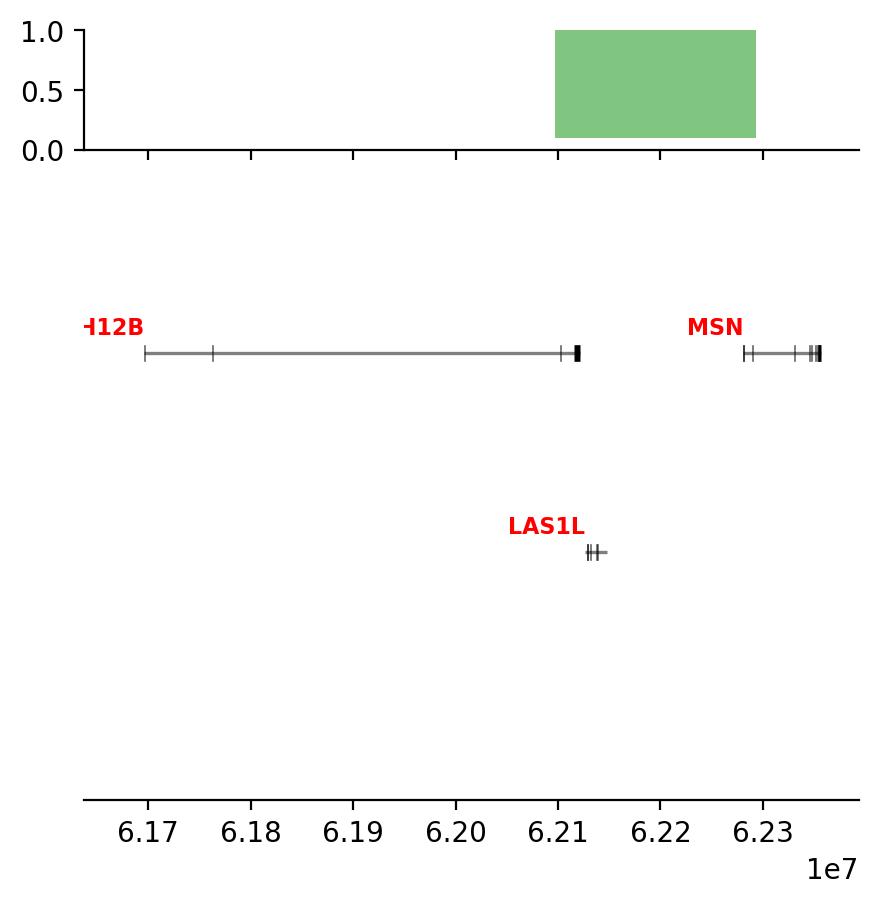

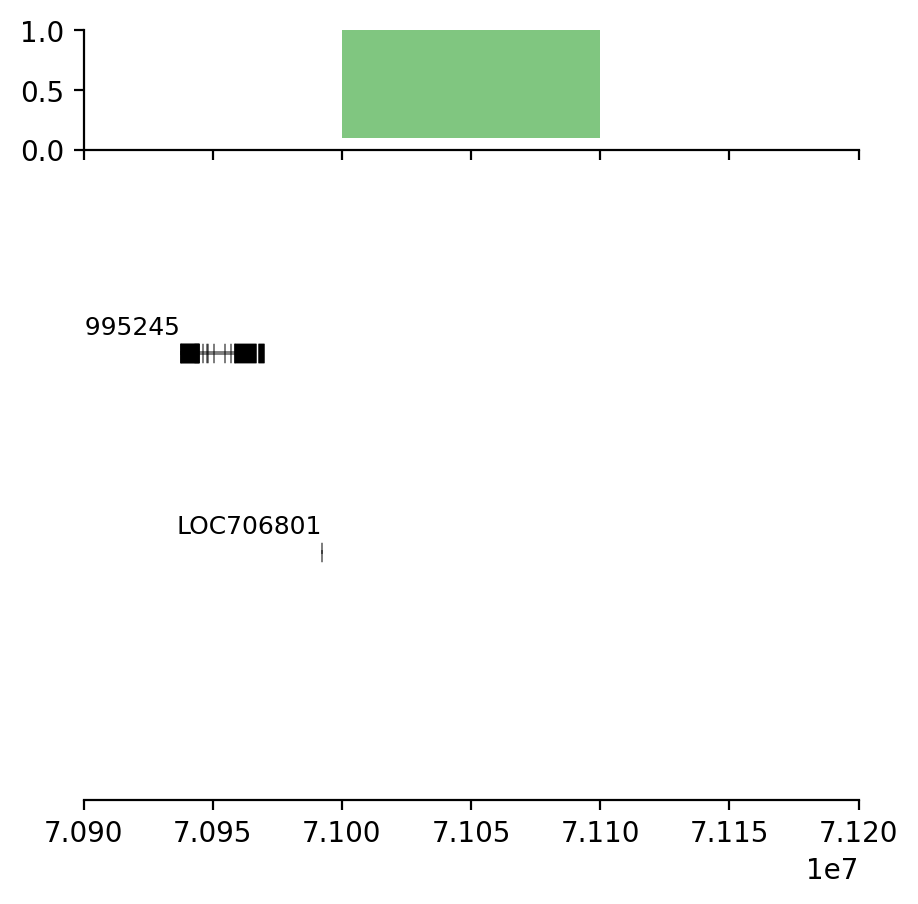

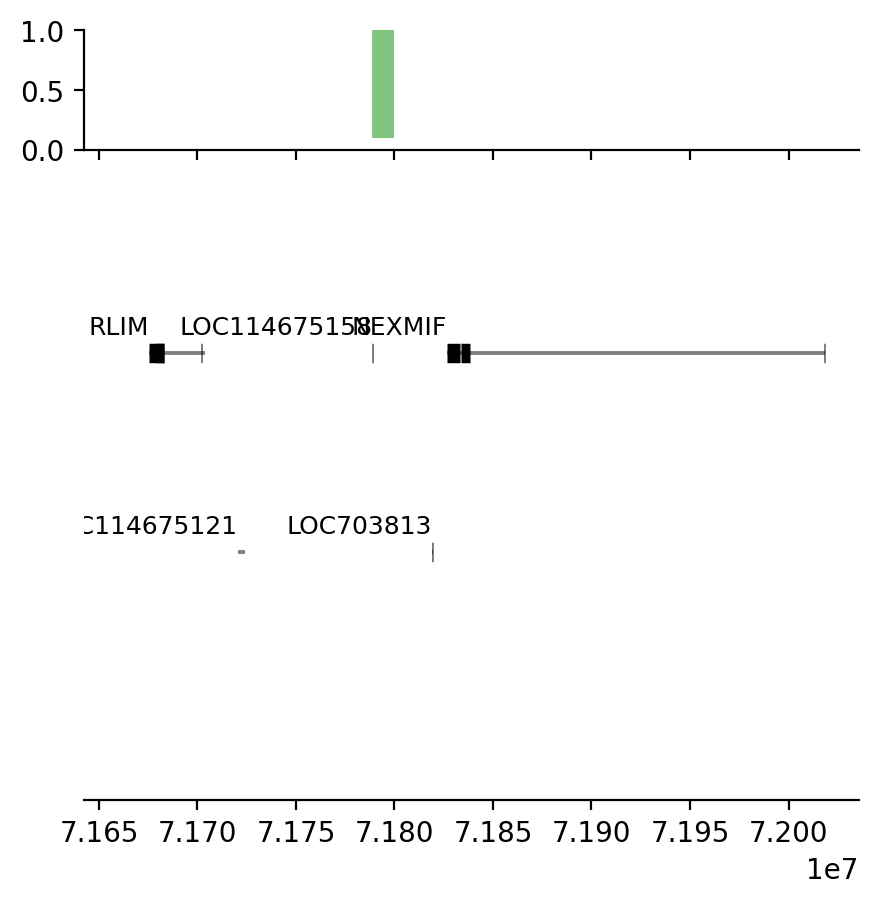

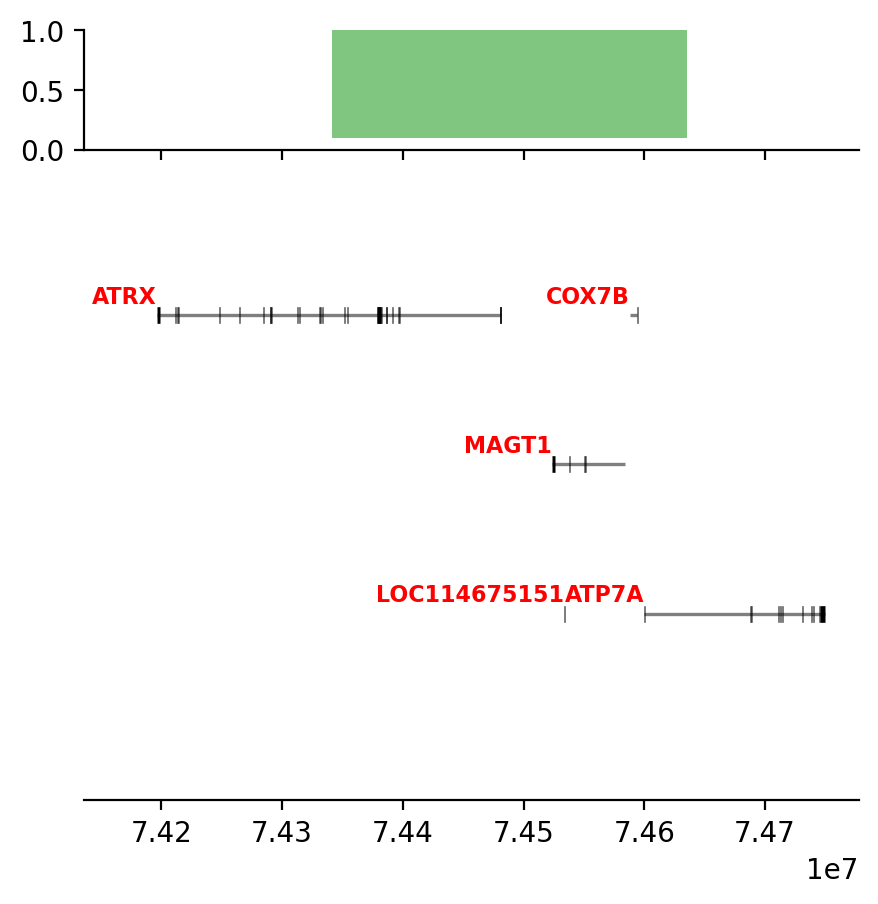

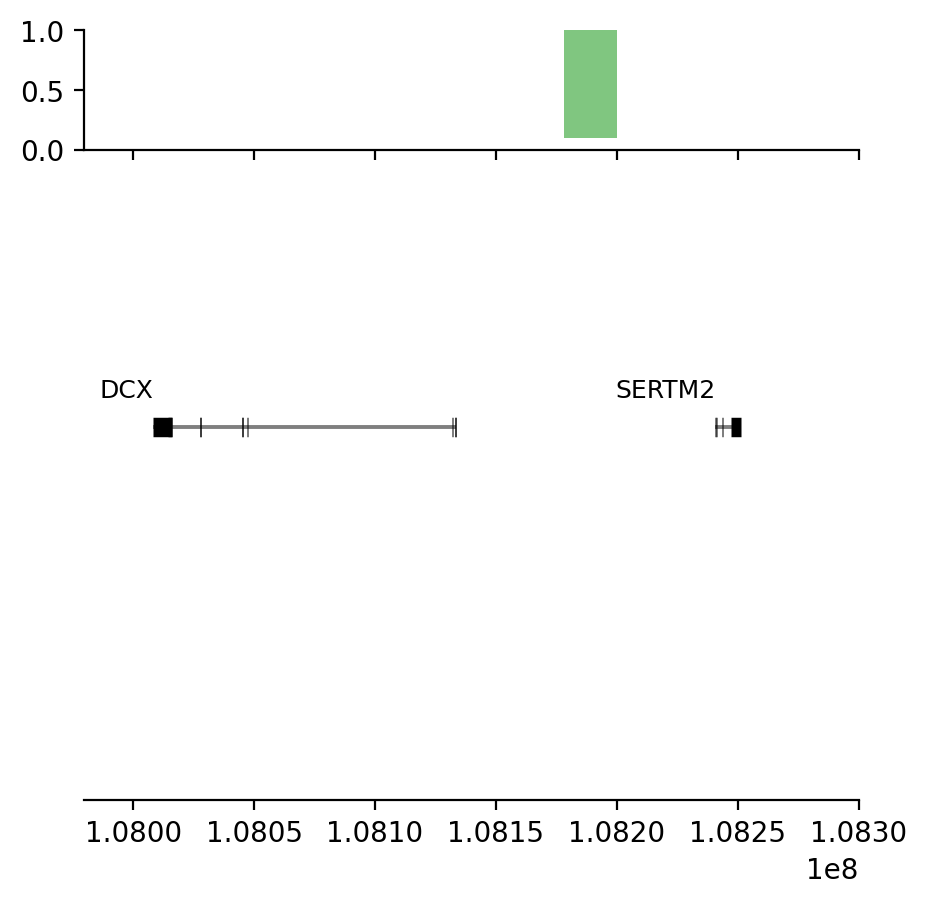

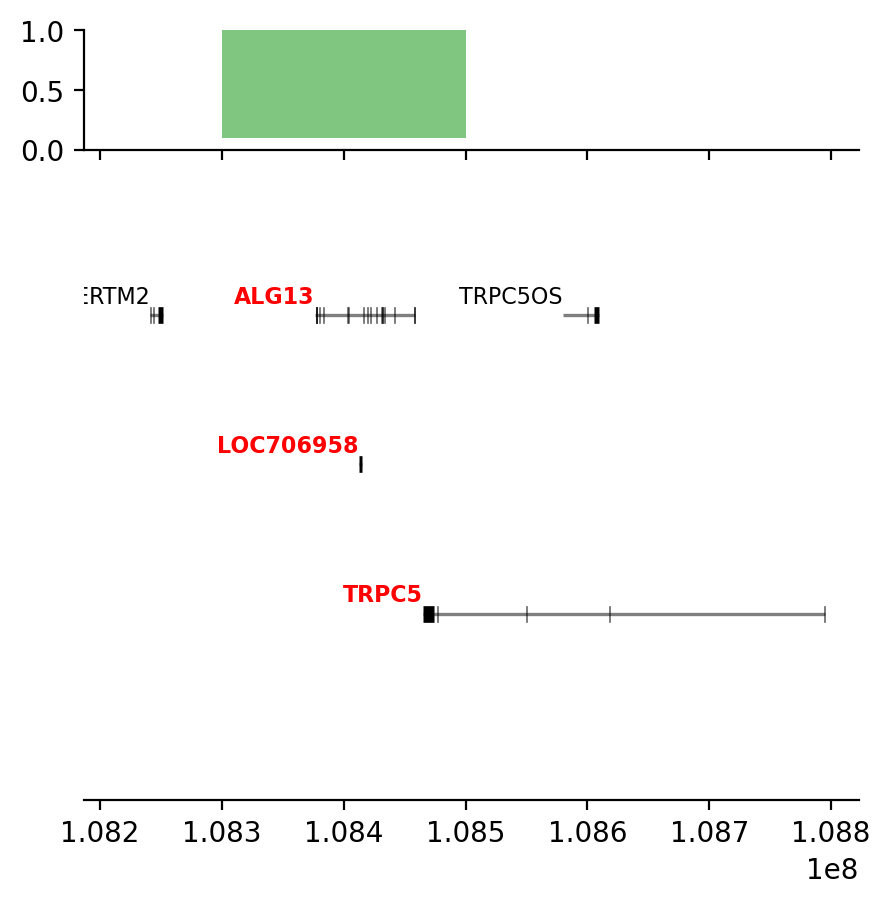

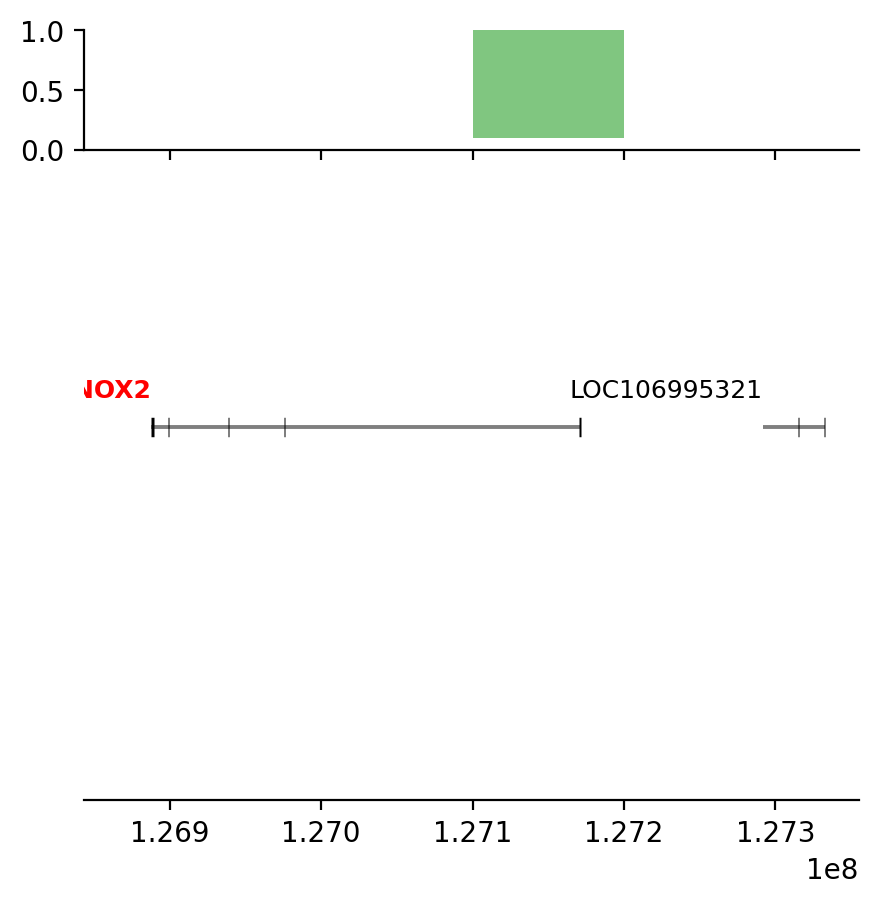

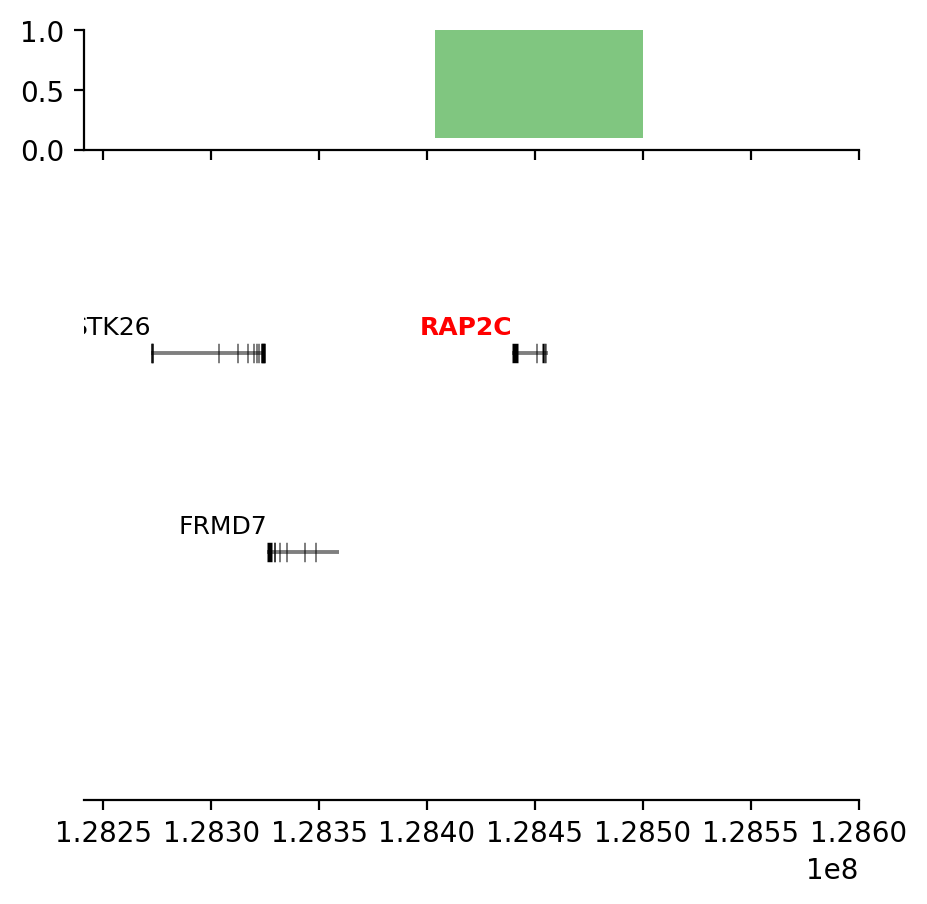

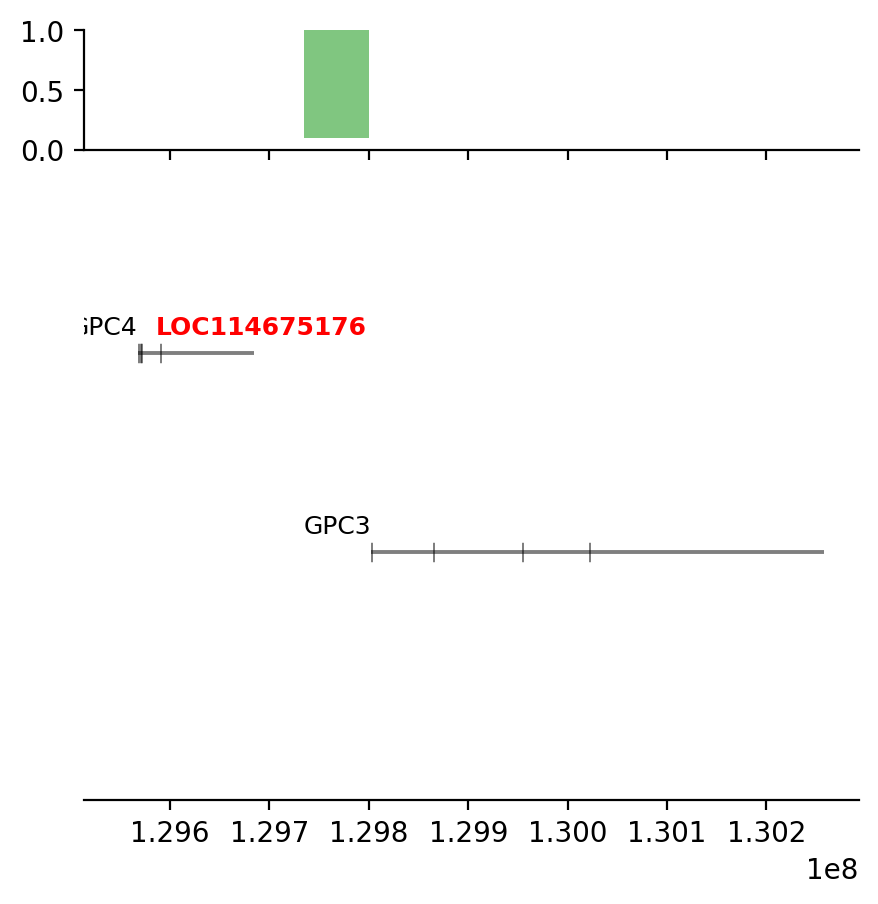

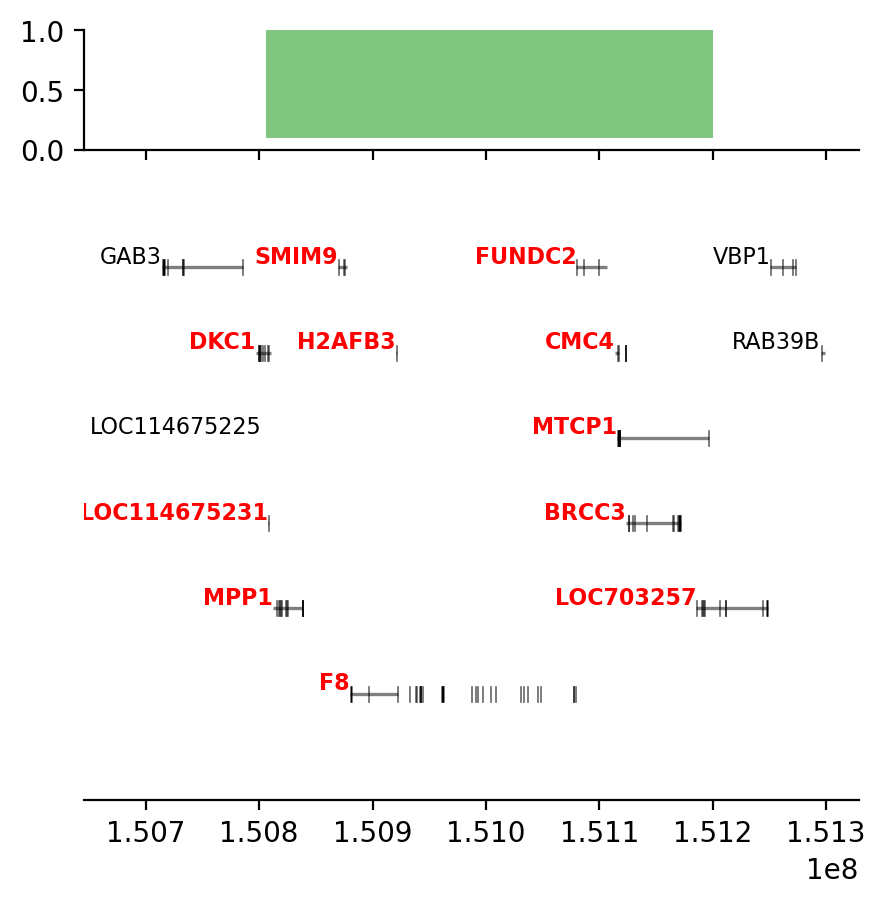

In [27]:
#| 
import geneinfo as gi
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


# Use the proximity test results to plot the ECH90 regions and the compartment edges

for i in full_intersect.index:
    start_idx = i
    end_idx = i

    start = full_intersect['start'][start_idx]
    end = full_intersect['end'][end_idx]

    rectangles = [Rectangle(
        (start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6) for start, end in zip(full_intersect['start'][start_idx:end_idx+1], full_intersect['end'][start_idx:end_idx+1])]

    pc = PatchCollection(rectangles, match_original=True)

    ax = gi.gene_plot('chrX', start-100_000, end+100_000, assembly='rheMac10', 
                    highlight=genes_list,
                    despine=True,
                    figsize=(5, 5),
                    aspect=5,
                    )
    ax.add_collection(pc)

### What can I do with the list of genes on the edges?

#### GO enrichment?

In [49]:
mmul_x_genes = gi.get_genes_region_dataframe('chrX', 0, 155_000_000, assembly='rheMac10')

In [50]:
mmul_x_genelist = mmul_x_genes['name'].unique().tolist()

In [51]:
gene_list = genes['name'].unique().tolist()
taxid = 9544
gi.email('sojernj@gmail.com')
#gi.go_annotation_table(taxid=taxid)

#gi.show_go_evidence_codes()

go_terms = gi.get_go_terms_for_genes(gene_list, taxid=taxid)


In [53]:
len(go_terms)
#gene_list[:5]


127

In [55]:
results = gi.go_enrichment(
    # Use human taxid as a start
    gene_list, 
    alpha=0.05,
    terms=go_terms)

geneinfo_cache/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms; optional_attrs(def relationship)


Could not map gene symbol "MIR7206" to ncbi id
Could not map gene symbol "LOC696657" to ncbi id
Could not map gene symbol "LOC114675180" to ncbi id


HTTPError: 400 Client Error: Bad Request for url: https://rest.ensembl.org/xrefs/id/%5B'ENSG00000207758'%5D